<a href="https://colab.research.google.com/github/SuzanaKstro/DatathonFiap/blob/main/TC5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Ferramenta para Recrutamento Decision - Datathon Pós Tech Fiap


#### Este notebook contém todo o processo de leitura, tratamento, análise e modelagem
#### utilizando dados da empresa Decision visando otimizar o processo de recrutamento.

# 1. Importações e Caminhos dos Arquivos

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


# Caminhos dos arquivos JSON

In [13]:
caminho_vagas = r'/content/vagas.json'
caminho_prospects = r'/content/prospects.json'
caminho_applicants = r'/content/applicants.json'

# 2. Leitura e Normalização de `vagas.json`

In [14]:
with open(caminho_vagas, encoding='utf-8') as f:
    raw_vagas = json.load(f)

In [15]:
lista_vagas = []
for id_vaga, dados in raw_vagas.items():
    dados['id_vaga'] = id_vaga
    lista_vagas.append(dados)


In [16]:
df_vagas = pd.json_normalize(lista_vagas)
print(f'Vagas carregadas: {df_vagas.shape}')


Vagas carregadas: (14081, 45)


# 3. Leitura e Normalização de `prospects.json` (com estrutura mista)


In [17]:
with open(caminho_prospects, encoding='utf-8') as f:
    raw_prospects = json.load(f)


In [18]:
lista_prospects = []
for id_vaga, conteudo in raw_prospects.items():
    if isinstance(conteudo, list):
        for candidato in conteudo:
            if isinstance(candidato, dict):
                candidato['id_vaga'] = id_vaga
                lista_prospects.append(candidato)
    elif isinstance(conteudo, dict) and 'prospects' in conteudo:
        for candidato in conteudo['prospects']:
            if isinstance(candidato, dict):
                candidato['id_vaga'] = id_vaga
                lista_prospects.append(candidato)

In [19]:
df_prospeccoes = pd.json_normalize(lista_prospects)
print(f'Prospecções carregadas: {df_prospeccoes.shape}')

Prospecções carregadas: (53759, 8)


# 4. Leitura e Normalização de `applicants.json`

In [20]:
lista_candidatos = []
with open(caminho_applicants, encoding='utf-8') as f:
    try:
        raw_candidatos = json.load(f)
    except json.JSONDecodeError as e:
        print("Erro ao carregar JSON completo. Tentando extrair manualmente...")

        f.seek(0)
        for i, linha in enumerate(f):
            try:
                candidato = json.loads(linha)
                lista_candidatos.append(candidato)
            except:
                print(f"Linha inválida na {i}")


In [21]:
with open(caminho_applicants, encoding='utf-8') as f:
    raw_candidatos = json.load(f)

lista_candidatos = []
for id_candidato, dados in raw_candidatos.items():
    dados['id_candidato'] = id_candidato
    lista_candidatos.append(dados)

df_candidatos = pd.json_normalize(lista_candidatos)
print(f'Candidatos carregados: {df_candidatos.shape}')

Candidatos carregados: (42482, 58)


# 5. Visualização Inicial

In [22]:
print("\nVagas:")
print(df_vagas.head())

print("\nProspecções:")
print(df_prospeccoes.head())

print("\nCandidatos:")
print(df_candidatos.head())


Vagas:
  id_vaga informacoes_basicas.data_requicisao  \
0    5185                          04-05-2021   
1    5184                          04-05-2021   
2    5183                          04-05-2021   
3    5182                          04-05-2021   
4    5181                          04-05-2021   

  informacoes_basicas.limite_esperado_para_contratacao  \
0                                         00-00-0000     
1                                         00-00-0000     
2                                         00-00-0000     
3                                         18-05-2021     
4                                         00-00-0000     

                     informacoes_basicas.titulo_vaga  \
0                                   Operation Lead -   
1                             Consultor PP/QM Sênior   
2                              ANALISTA PL/JR C/ SQL   
3                     Technical Architect - 11894809   
4  Consultor SAP AUTHORIZATION (BCA) -Pleno / Sênior   

  informaco

# 6. Análise Exploratória (EDA)

In [23]:
print("Vagas:")
df_vagas.info()

print("\nProspecções:")
df_prospeccoes.info()

print("\nCandidatos:")
df_candidatos.info()
# %% [markdown]
# ### 6.2 Verificação dos nomes das colunas
# %%
print("Colunas disponíveis em df_vagas:")
print(df_vagas.columns.tolist())
# %%
print("Colunas disponíveis em df_prospeccoes:")
print(df_prospeccoes.columns.tolist())
# %%
print("Colunas disponíveis em df_candidatos:")
print(df_candidatos.columns.tolist())

Vagas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14081 entries, 0 to 14080
Data columns (total 45 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   id_vaga                                               14081 non-null  object
 1   informacoes_basicas.data_requicisao                   14081 non-null  object
 2   informacoes_basicas.limite_esperado_para_contratacao  14081 non-null  object
 3   informacoes_basicas.titulo_vaga                       14081 non-null  object
 4   informacoes_basicas.vaga_sap                          14081 non-null  object
 5   informacoes_basicas.cliente                           14081 non-null  object
 6   informacoes_basicas.solicitante_cliente               14081 non-null  object
 7   informacoes_basicas.empresa_divisao                   14081 non-null  object
 8   informacoes_basicas.requisitante                      14081

### 6.1 Quantidade de registros únicos de vagas, candidadtos e prospecções

In [24]:
print(f"Total de vagas: {df_vagas['id_vaga'].nunique():,.0f}".replace(',', '.'))

print(f"Total de candidatos: {df_candidatos['id_candidato'].nunique():,.0f}".replace(',', '.'))

print(f"Total de prospecções: {df_prospeccoes.shape[0]:,.0f}".replace(',', '.'))

Total de vagas: 14.081
Total de candidatos: 42.482
Total de prospecções: 53.759


### 6.3 Distribuição dos candidatos

In [25]:
if 'situacao_candidado' in df_prospeccoes.columns:
    print("Distribuição da situação dos candidatos:")
    print(df_prospeccoes['situacao_candidado'].value_counts(dropna=False))
else:
    print("Coluna 'situacao' não encontrada. Verifique o nome correto.")

Distribuição da situação dos candidatos:
situacao_candidado
Prospect                          20021
Encaminhado ao Requisitante       16122
Inscrito                           3980
Não Aprovado pelo Cliente          3492
Contratado pela Decision           2758
Desistiu                           2349
Não Aprovado pelo RH               1765
Não Aprovado pelo Requisitante      765
Entrevista Técnica                  579
Sem interesse nesta vaga            576
Entrevista com Cliente              469
Em avaliação pelo RH                375
Contratado como Hunting             226
Aprovado                            209
Desistiu da Contratação              59
Documentação PJ                       4
Documentação CLT                      3
Recusado                              2
Documentação Cooperado                2
Encaminhar Proposta                   2
Proposta Aceita                       1
Name: count, dtype: int64


In [26]:
df_candidatos['formacao_e_idiomas.ano_conclusao'].unique()



array([nan, '2012', '0', '2011', '2007', '2020', '2015', '2018', '2005',
       '2021', '2022', '2016', '2002', '2024', '2019', '1999', '1993',
       '2014', '2010', '1980', '2000', '2017', '2023', '2013', '2009',
       '2008', '2006', '2', '1985', '1998', '1995', '5', '1988', '1996',
       '2003', '1983', '1994', '1997', '2026', '1992', '2001', '1979',
       '1987', '1984', '1', '1986', '2004', '1990', '3', '1989', '4',
       '204', '87', '1981', '2027', '2025', '1982', '1975', '13000',
       '1922', '1991', '217', '13', '1978', '1967', '1976', '94', '1020',
       '1974', '198', '22', '21', '2925', '25', '91', '420', '9990',
       '1977', '20', '2110', '2204'], dtype=object)

In [28]:
df_vagas['informacoes_basicas.tipo_contratacao'].unique()


array(['CLT Full', 'PJ/Autônomo, CLT Full', 'PJ/Autônomo', 'CLT Cotas',
       'Cooperado', 'Hunting', 'Hunting, PJ/Autônomo, CLT Full',
       'PJ/Autônomo, CLT Cotas', 'CLT Full, PJ/Autônomo',
       'PJ/Autônomo, Hunting', 'PJ/Autônomo, Cooperado',
       'Cooperado, PJ/Autônomo', 'CLT Full, CLT Cotas, PJ/Autônomo',
       'Estagiário', 'PJ/Autônomo, Cooperado, CLT Cotas',
       'Hunting, PJ/Autônomo', '',
       'Candidato poderá escolher, PJ/Autônomo',
       'PJ/Autônomo, Cooperado, CLT Full',
       'CLT Full, Cooperado, PJ/Autônomo', 'CLT Full, Hunting',
       'Hunting, PJ/Autônomo, Cooperado',
       'Candidato poderá escolher, Hunting, PJ/Autônomo',
       'Cooperado, CLT Full', 'CLT Cotas, PJ/Autônomo',
       'CLT Full, Cooperado',
       'CLT Full, CLT Cotas, Cooperado, Estagiário, PJ/Autônomo',
       'Hunting, CLT Full', 'PJ/Autônomo, CLT Cotas, CLT Full',
       'CLT Cotas, CLT Full', 'CLT Full, CLT Cotas',
       'CLT Cotas, Cooperado, Estagiário, PJ/Autônomo',
     

In [29]:
df_vagas['informacoes_basicas.prioridade_vaga'].unique()

array(['', 'Alta: Alta complexidade 3 a 5 dias',
       'Média: Média complexidade 6 a 10 dias',
       'Baixa: Baixa complexidade 11 a 30 dias'], dtype=object)

In [30]:
df_vagas['perfil_vaga.estado'].unique()

array(['São Paulo', 'Paraná', 'Pernambuco', 'Minas Gerais',
       'Rio de Janeiro', 'Rio Grande do Sul', 'Ceará', 'Rondônia',
       'Distrito Federal', 'Paraíba', 'Alagoas', 'Bahia', 'Mato Grosso',
       'Sergipe', 'Santa Catarina', '', 'Amazonas', 'Piauí', 'Acre',
       'Pará', 'Maranhão', 'Espirito Santo', 'Goiás',
       'Rio Grande do Norte', 'Amapá', 'Mato Grosso do Sul', 'Tocantins'],
      dtype=object)

In [31]:
df_vagas['perfil_vaga.cidade'].unique()

array(['São Paulo', 'Londrina', 'Recife', 'Nova Lima', 'Belo Horizonte',
       'Rio de Janeiro', 'Curitiba', 'Hortolândia', 'Porto Alegre',
       'Limeira', 'Barueri', 'São José dos Campos',
       'São Bernardo do Campo', '', 'Campinas', 'Fortaleza', 'Cacoal',
       'Brasília', 'Santo André', 'São Leopoldo', 'Campina Grande',
       'Água Branca', 'Resende', 'Salvador', 'São João da Boa Vista',
       'Cuiabá', 'Araraquara', 'Osasco', 'Jundiaí', 'Maceió', 'Camaçari',
       'Arroio dos Ratos', 'Aracaju', 'São Pedro', 'Blumenau',
       'Santana de Parnaíba', 'Belo Oriente', 'Santos', 'Manaus',
       'Uberlândia', 'Jaguariúna', 'Cruzeiro', 'Bauru', 'Bebedouro',
       'Muriaé', 'Teresina', 'Rio Branco', 'Sete Lagoas',
       'Ribeirão Preto', 'Varginha', 'Serra Talhada', 'Teófilo Otoni',
       'Juiz de Fora', 'Marília', 'Araçatuba', 'Sabino', 'Vinhedo',
       'Belford Roxo', 'Sorocaba', 'Guarulhos', 'Maringá', 'Louveira',
       'Criciúma', 'Itatiaia', 'Telêmaco Borba', 'Araxá', 

In [32]:
df_vagas['perfil_vaga.regiao'].unique()

array(['', 'Oeste', 'Sul', 'Centro', 'Leste', 'Outra', 'Grande São Paulo',
       'ABC', 'Niterói', 'Baixada Santista', 'Norte'], dtype=object)

In [34]:
df_vagas['perfil_vaga.nivel_academico'].unique()

array(['Ensino Superior Completo', 'Ensino Médio Completo',
       'Ensino Técnico Completo', 'Ensino Superior Cursando',
       'Ensino Superior Incompleto', 'Pós Graduação Completo',
       'Doutorado Cursando', 'Pós Graduação Incompleto',
       'Doutorado Completo', 'Ensino Técnico Cursando',
       'Pós Graduação Cursando', 'Mestrado Completo',
       'Ensino Fundamental Completo', 'Ensino Médio Incompleto',
       'Ensino Técnico Incompleto', 'Mestrado Cursando'], dtype=object)

In [35]:
df_vagas['perfil_vaga.nivel_ingles'].unique()

array(['Avançado', 'Fluente', 'Nenhum', 'Básico', 'Intermediário',
       'Técnico'], dtype=object)

In [36]:
df_vagas['perfil_vaga.nivel_espanhol'].unique()

array(['Fluente', 'Nenhum', 'Intermediário', 'Básico', 'Avançado', '',
       'Técnico'], dtype=object)

In [37]:
df_vagas['perfil_vaga.outro_idioma'].unique()

array(['', 'Mandarim ou Russo', 'Nenhum', 'Avançado', 'Português Fluente',
       'Português Avançado', 'Português Básico', 'Francês Básico',
       'Fluente', 'Básico', 'Francês Intermediário',
       'Mandarim - Desejável', 'Alemão Fluente', 'Francês Fluente',
       'Alemão Avançado', 'Português Intermediário', 'Português'],
      dtype=object)

In [38]:
df_vagas['perfil_vaga.areas_atuacao'].unique()

array(['TI - Sistemas e Ferramentas-',
       'TI - Desenvolvimento/Programação-', 'TI - Projetos-', 'TI - SAP-',
       'TI - Infraestrutura-', 'Gestão e Alocação de Recursos de TI-',
       'Administrativa-', 'TI - Processos e Negócios-',
       'Recursos Humanos-', 'TI - Desenvolvimento/Design-',
       'TI - Suporte-', 'Financeira/Controladoria-',
       'TI - Desenvolvimento/Mobile-', 'TI - Qualidade/Testes-',
       'Comercial-', 'TI - Banco de Dados-', 'TI - Arquitetura-',
       'TI - Governança-', 'TI - Telecom-',
       'Gestão e Alocação de Recursos de TI-TI - SAP-',
       'Administrativa-Financeira/Controladoria-',
       'Administrativa-Recursos Humanos-',
       'Gestão e Alocação de Recursos de TI-TI - Arquitetura-',
       'Financeira/Controladoria-TI - Projetos-',
       'Gestão e Alocação de Recursos de TI-TI - Suporte-',
       'Gestão e Alocação de Recursos de TI-TI - Projetos-',
       'Gestão e Alocação de Recursos de TI-TI - Desenvolvimento/Programação-',
      

In [39]:
df_candidatos['informacoes_profissionais.area_atuacao'].unique()

array(['', 'Administrativa', 'Comercial', 'Financeira/Controladoria',
       'Administrativa, Comercial, Financeira/Controladoria',
       'TI - Arquitetura, TI - Infraestrutura, TI - Projetos',
       'TI - Infraestrutura', 'TI - Desenvolvimento/Programação',
       'TI - Suporte',
       'Administrativa, Financeira/Controladoria, Recursos Humanos',
       'TI - Projetos', 'Recursos Humanos', 'Administrativa, Comercial',
       'TI - Governança', 'TI - Processos e Negócios',
       'TI - Sistemas e Ferramentas', 'TI - SAP', 'TI - Banco de Dados',
       'TI - Banco de Dados, TI - Processos e Negócios, TI - Projetos, TI - Sistemas e Ferramentas, TI - Suporte',
       'TI - Qualidade/Testes',
       'Administrativa, Comercial, Financeira/Controladoria, Gestão e Alocação de Recursos de TI, Recursos Humanos, Relacionamento Técnico, TI - Banco de Dados, TI - SAP',
       'Relacionamento Técnico, TI - Infraestrutura, TI - Qualidade/Testes, TI - Sistemas e Ferramentas, TI - Suporte',
       

In [40]:
df_candidatos['informacoes_profissionais.nivel_profissional'].unique()

array(['', 'Sênior', 'Especialista', 'Júnior', 'Pleno', 'Analista',
       'Gerente', 'Líder', 'Outro', 'Técnico de Nível Médio',
       'Estagiário'], dtype=object)

In [41]:
df_candidatos['informacoes_profissionais.nivel_profissional'].unique()

array(['', 'Sênior', 'Especialista', 'Júnior', 'Pleno', 'Analista',
       'Gerente', 'Líder', 'Outro', 'Técnico de Nível Médio',
       'Estagiário'], dtype=object)

In [42]:
df_candidatos['formacao_e_idiomas.nivel_academico'].unique()

array(['', 'Ensino Superior Incompleto', 'Ensino Superior Completo',
       'Ensino Técnico Completo', 'Ensino Superior Cursando',
       'Pós Graduação Completo', 'Pós Graduação Cursando',
       'Pós Graduação Incompleto', 'Ensino Técnico Cursando',
       'Ensino Fundamental Completo', 'Ensino Médio Completo',
       'Doutorado Completo', 'Mestrado Completo', 'Mestrado Incompleto',
       'Mestrado Cursando', 'Doutorado Incompleto',
       'Ensino Técnico Incompleto', 'Ensino Médio Cursando',
       'Ensino Médio Incompleto', 'Ensino Fundamental Cursando',
       'Doutorado Cursando', 'Ensino Fundamental Incompleto'],
      dtype=object)

In [43]:
df_candidatos['formacao_e_idiomas.nivel_ingles'].unique()

array(['', 'Nenhum', 'Intermediário', 'Básico', 'Avançado', 'Fluente'],
      dtype=object)

In [44]:
df_candidatos['formacao_e_idiomas.nivel_espanhol'].unique()

array(['', 'Nenhum', 'Básico', 'Intermediário', 'Avançado', 'Fluente'],
      dtype=object)

In [45]:
df_candidatos['formacao_e_idiomas.outro_idioma'].unique()

array(['-', 'Português - Fluente', 'Francês - Intermediário',
       'Francês - Básico', 'Italiano - Avançado', 'Português -',
       'Italiano - Básico', 'Português - Avançado', 'Alemão - Básico',
       'Alemão -', 'Japonês - Básico', 'Japonês -', 'Alemão - Avançado',
       'Japonês - Avançado', 'Alemão - Intermediário', 'Russo - Básico',
       'Russo - Intermediário', 'Italiano - Intermediário',
       'Português - Intermediário', 'Japonês - Intermediário',
       'Mandarim - Básico', 'Francês - Avançado', 'Português - Nenhum',
       'Italiano -', 'Português - Básico', 'Francês - Fluente',
       'Italiano - Fluente', 'Japonês - Fluente', 'Japonês - Nenhum',
       'Russo - Fluente', 'Alemão - Nenhum', 'Francês -',
       'Alemão - Fluente'], dtype=object)

In [46]:
df_candidatos['formacao_e_idiomas.instituicao_ensino_superior'].unique()

array([nan, '', 'Universidade Paulista', 'METROCAMP',
       'Centro Universitário Adventista',
       'SP -> Centro Universitário de Santo André - UNIA',
       'Centro Universitário de Santo André - UNIA',
       'Unijorge - Salvador - BA', 'Faculdade Sumare',
       'UMESP - Universidade Metodista de São Paulo (2010).', 'Uninove',
       'FIAP', 'FATEC - BS', 'Instituição Mackenzi',
       'Faculdade Interação Americana', 'UNIBTA',
       'FASP (Faculdade Associada de São Paulo)',
       'Univille - Universidade da Regiao de Joinville',
       'FACULDADE TANCREDO NEVES',
       'UNIBAN-Universidade Bandeirante de São Paulo',
       'Fundação Getúlio Vargas',
       'ESAN - ESCOLA SUPERIOR DE ADMINISTRAÇÃO E NEGÓCIOS',
       'FATEC Baixada Santista', 'Universidade Estadual de Maringá – PR',
       'Senac - Ribeirão Preto - SP',
       'centro universitario dos guararapes', 'fgv', 'FUMEC', 'Mackenzie',
       'MG -> Faculdade Anhanguera', 'Faculdade Anhanguera',
       'Cruzeiro do s

## Análise item 6.3:
O número de prospecções é superior ao número de candidatos, pois um candidato pode se inscrever em várias vagas.
Isso é comum em processos seletivos, onde candidatos podem se candidatar a múltiplas oportunidades de emprego.

In [47]:
print("Valores nulos em df_vagas:")
print(df_vagas.isnull().sum().sort_values(ascending=False))

Valores nulos em df_vagas:
informacoes_basicas.nome_substituto                     13733
perfil_vaga.habilidades_comportamentais_necessarias     11396
informacoes_basicas.data_inicial                         9625
informacoes_basicas.data_final                           9625
informacoes_basicas.telefone                             4762
informacoes_basicas.nome                                 4456
perfil_vaga.equipamentos_necessarios                     2685
informacoes_basicas.superior_imediato                      42
id_vaga                                                     0
informacoes_basicas.data_requicisao                         0
informacoes_basicas.limite_esperado_para_contratacao        0
informacoes_basicas.titulo_vaga                             0
informacoes_basicas.vaga_sap                                0
informacoes_basicas.objetivo_vaga                           0
informacoes_basicas.prazo_contratacao                       0
informacoes_basicas.tipo_contratacao       

In [48]:
print("\nValores nulos em df_prospeccoes:")
print(df_prospeccoes.isnull().sum().sort_values(ascending=False))



Valores nulos em df_prospeccoes:
nome                  0
codigo                0
situacao_candidado    0
data_candidatura      0
ultima_atualizacao    0
comentario            0
recrutador            0
id_vaga               0
dtype: int64


In [49]:
print("\nValores nulos em df_candidatos:")
print(df_candidatos.isnull().sum().sort_values(ascending=False))


Valores nulos em df_candidatos:
formacao_e_idiomas.outro_curso                      41673
cargo_atual.id_ibrati                               41538
informacoes_profissionais.experiencias              41538
cargo_atual.email_superior_imediato                 41538
cargo_atual.nome_superior_imediato                  41538
cargo_atual.unidade                                 41538
cargo_atual.data_admissao                           41538
cargo_atual.cliente                                 41538
cargo_atual.cargo_atual                             41538
cargo_atual.projeto_atual                           41538
informacoes_profissionais.qualificacoes             41538
cargo_atual.email_corporativo                       41538
cargo_atual.data_ultima_promocao                    41538
informacoes_pessoais.download_cv                    36920
formacao_e_idiomas.cursos                           35273
formacao_e_idiomas.instituicao_ensino_superior      35273
formacao_e_idiomas.ano_conclusao       

# 6.5 Distribuição de status nas prospecções

In [50]:
if 'situacao_candidado' in df_prospeccoes.columns:
    print("Distribuição da situação dos candidatos:")
    print(df_prospeccoes['situacao_candidado'].value_counts(dropna=False))
else:
    print("Coluna 'situacao' não encontrada. Verifique o nome correto.")

Distribuição da situação dos candidatos:
situacao_candidado
Prospect                          20021
Encaminhado ao Requisitante       16122
Inscrito                           3980
Não Aprovado pelo Cliente          3492
Contratado pela Decision           2758
Desistiu                           2349
Não Aprovado pelo RH               1765
Não Aprovado pelo Requisitante      765
Entrevista Técnica                  579
Sem interesse nesta vaga            576
Entrevista com Cliente              469
Em avaliação pelo RH                375
Contratado como Hunting             226
Aprovado                            209
Desistiu da Contratação              59
Documentação PJ                       4
Documentação CLT                      3
Recusado                              2
Documentação Cooperado                2
Encaminhar Proposta                   2
Proposta Aceita                       1
Name: count, dtype: int64


# Gráfico da distribuição da situação dos candidatos

<ipython-input-51-399582984>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=situacao_counts.values, y=situacao_counts.index, palette="viridis")


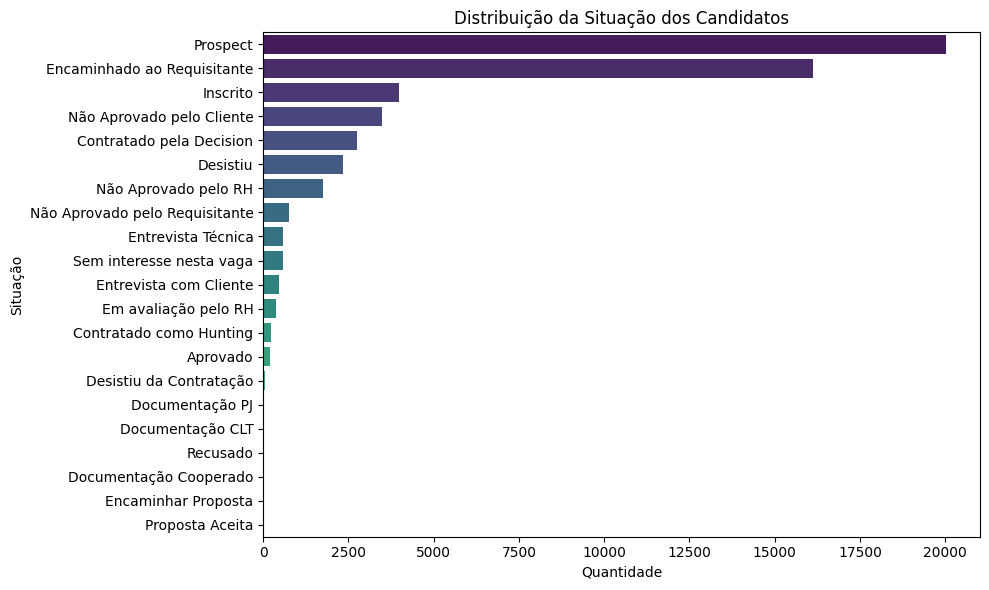

In [51]:
if 'situacao_candidado' in df_prospeccoes.columns:
    situacao_counts = df_prospeccoes['situacao_candidado'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=situacao_counts.values, y=situacao_counts.index, palette="viridis")
    plt.title("Distribuição da Situação dos Candidatos")
    plt.xlabel("Quantidade")
    plt.ylabel("Situação")
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'situacao' não encontrada. Verifique o nome correto.")
    print("Coluna 'situacao' não encontrada. Verifique o nome correto.")

# Tabela com percentual por situação

In [52]:
percentual = (situacao_counts / situacao_counts.sum() * 100).round(2)
df_percentual = pd.DataFrame({
    'Situação': situacao_counts.index,
    'Quantidade': situacao_counts.values,
    'Percentual (%)': percentual.values
})
print("Tabela com percentuais da situação dos candidatos em relação ao total de candidaturas:")
print(df_percentual)

Tabela com percentuais da situação dos candidatos em relação ao total de candidaturas:
                          Situação  Quantidade  Percentual (%)
0                         Prospect       20021           37.24
1      Encaminhado ao Requisitante       16122           29.99
2                         Inscrito        3980            7.40
3        Não Aprovado pelo Cliente        3492            6.50
4         Contratado pela Decision        2758            5.13
5                         Desistiu        2349            4.37
6             Não Aprovado pelo RH        1765            3.28
7   Não Aprovado pelo Requisitante         765            1.42
8               Entrevista Técnica         579            1.08
9         Sem interesse nesta vaga         576            1.07
10          Entrevista com Cliente         469            0.87
11            Em avaliação pelo RH         375            0.70
12         Contratado como Hunting         226            0.42
13                        Aprov

# 6.6 Junção dos dados para modelagem

# Renomear a coluna 'codigo' para 'id_candidato' para fazer o merge corretamente

In [53]:
df_prospeccoes = df_prospeccoes.rename(columns={'codigo': 'id_candidato'})

# Juntar prospecções com vagas

In [54]:
df_completo = df_prospeccoes.merge(df_vagas, on='id_vaga', how='left')

# Juntar com candidatos

In [55]:
df_completo = df_completo.merge(df_candidatos, on='id_candidato', how='left')

# Verificar o resultado

In [56]:
print(f"Shape final do DataFrame consolidado: {df_completo.shape}")
print(df_completo[['id_vaga', 'id_candidato', 'situacao_candidado']].head())

Shape final do DataFrame consolidado: (53759, 110)
  id_vaga id_candidato           situacao_candidado
0    4530        25632  Encaminhado ao Requisitante
1    4530        25529  Encaminhado ao Requisitante
2    4531        25364     Contratado pela Decision
3    4531        25360  Encaminhado ao Requisitante
4    4533        26338     Contratado pela Decision


In [57]:
print("Colunas disponíveis em df_completo:")
print(df_completo.columns.tolist())

Colunas disponíveis em df_completo:
['nome', 'id_candidato', 'situacao_candidado', 'data_candidatura', 'ultima_atualizacao', 'comentario', 'recrutador', 'id_vaga', 'informacoes_basicas.data_requicisao', 'informacoes_basicas.limite_esperado_para_contratacao', 'informacoes_basicas.titulo_vaga', 'informacoes_basicas.vaga_sap', 'informacoes_basicas.cliente', 'informacoes_basicas.solicitante_cliente', 'informacoes_basicas.empresa_divisao', 'informacoes_basicas.requisitante', 'informacoes_basicas.analista_responsavel', 'informacoes_basicas.tipo_contratacao', 'informacoes_basicas.prazo_contratacao', 'informacoes_basicas.objetivo_vaga', 'informacoes_basicas.prioridade_vaga', 'informacoes_basicas.origem_vaga', 'informacoes_basicas.superior_imediato', 'informacoes_basicas.nome', 'informacoes_basicas.telefone', 'perfil_vaga.pais', 'perfil_vaga.estado', 'perfil_vaga.cidade', 'perfil_vaga.bairro', 'perfil_vaga.regiao', 'perfil_vaga.local_trabalho', 'perfil_vaga.vaga_especifica_para_pcd', 'perfil_va

In [58]:
print("Registros em df_prospeccoes:", df_prospeccoes.shape[0])
print("Registros após merge (df_completo):", df_completo.shape[0])


Registros em df_prospeccoes: 53759
Registros após merge (df_completo): 53759


In [59]:
print("Vagas ausentes no merge:", df_completo['informacoes_basicas.titulo_vaga'].isnull().sum())
print("Candidatos ausentes no merge:", df_completo['infos_basicas.nome'].isnull().sum())

Vagas ausentes no merge: 24
Candidatos ausentes no merge: 8664


In [60]:
print(df_prospeccoes['id_candidato'].dtype)
print(df_candidatos['id_candidato'].dtype)

object
object


# Conferindo de maneira aleatoria os dados do merge

In [61]:
df_completo[['id_candidato', 'id_vaga', 'situacao_candidado',
             'perfil_vaga.nivel_ingles', 'formacao_e_idiomas.nivel_ingles',
             'informacoes_profissionais.area_atuacao']].sample(5)

,id_candidato,id_vaga,situacao_candidado,perfil_vaga.nivel_ingles,formacao_e_idiomas.nivel_ingles,informacoes_profissionais.area_atuacao
23349,23854,4010,Inscrito,Básico,Nenhum,Administrativa
42927,42190,11120,Desistiu,Básico,,
50667,47980,12569,Prospect,Básico,NaN,NaN
45246,46586,11554,Prospect,Avançado,NaN,NaN
16956,12050,9870,Encaminhado ao Requisitante,Básico,,


# 7. Criação da variável alvo:`foi_contratado`




In [62]:
situacoes_contratado = ['Contratado pela Decision', 'Contratado como Hunting']

In [63]:
df_completo['foi_contratado'] = df_completo['situacao_candidado'].isin(situacoes_contratado).astype(int)

In [64]:
print("Distribuição da variável `foi_contratado`:")
print(df_completo['foi_contratado'].value_counts())

Distribuição da variável `foi_contratado`:
foi_contratado
0    50775
1     2984
Name: count, dtype: int64


In [65]:
percentual = (df_completo['foi_contratado'].value_counts(normalize=True) * 100).round(2)
print("\nPercentual:")
print(percentual)


Percentual:
foi_contratado
0    94.45
1     5.55
Name: proportion, dtype: float64


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
contagem = df_completo['foi_contratado'].value_counts().sort_index()
labels = ['Não contratado', 'Contratado']

<ipython-input-68-796112815>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem.values, y=labels, palette="crest")


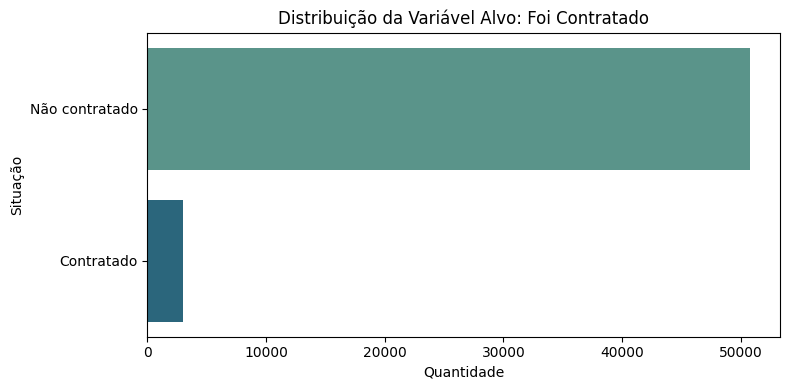

In [68]:
plt.figure(figsize=(8, 4))
sns.barplot(x=contagem.values, y=labels, palette="crest")
plt.title("Distribuição da Variável Alvo: Foi Contratado")
plt.xlabel("Quantidade")
plt.ylabel("Situação")
plt.tight_layout()
plt.show()

In [69]:
contagem = df_completo['foi_contratado'].value_counts().sort_index()
# Percentual
percentual = df_completo['foi_contratado'].value_counts(normalize=True).sort_index() * 100

# Monta DataFrame
df_alvo = pd.DataFrame({
    'Classe': ['Não Contratado', 'Contratado'],
    'Quantidade': contagem.values,
    'Percentual (%)': percentual.round(2).values
})

print("\nTabela da variável alvo (`foi_contratado`):")
print(df_alvo)


Tabela da variável alvo (`foi_contratado`):
           Classe  Quantidade  Percentual (%)
0  Não Contratado       50775           94.45
1      Contratado        2984            5.55


#   8. Seleção e Engenharia de Features

 Nesta etapa, selecionamos colunas com potencial explicativo para a contratação, considerando:

- Relevância para o processo seletivo
- Presença de dados (poucos valores nulos)
- Facilidade de tratamento (sem estruturas aninhadas ou texto livre)


## 8.1 Seleção inicial de colunas relevantes


In [70]:
colunas_modelo = [
    'perfil_vaga.estado',
    'perfil_vaga.cidade',
    'perfil_vaga.regiao',
    'perfil_vaga.nivel_academico',
    'perfil_vaga.nivel_ingles',
    'perfil_vaga.nivel_espanhol',
    'perfil_vaga.areas_atuacao',
    'perfil_vaga.vaga_especifica_para_pcd',
    'informacoes_basicas.prioridade_vaga',
    'informacoes_profissionais.area_atuacao',
    'informacoes_profissionais.nivel_profissional',
    'formacao_e_idiomas.nivel_academico',
    'formacao_e_idiomas.nivel_ingles',
    'formacao_e_idiomas.nivel_espanhol',
    'formacao_e_idiomas.outro_idioma',
    'formacao_e_idiomas.instituicao_ensino_superior',
    'formacao_e_idiomas.ano_conclusao',
    'foi_contratado'  # variável alvo
]

###8.2 Tratamento de valores ausentes

- Colunas categóricas: preenchidas com "Desconhecido"
- Colunas numéricas: preenchidas com a mediana da variável

In [71]:
df_modelo = df_completo[colunas_modelo].copy()

In [73]:
colunas_categoricas = df_modelo.select_dtypes(include=['object', 'category']).columns.tolist()
colunas_numericas = df_modelo.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [75]:
from sklearn.impute import SimpleImputer

# Detectar colunas primeiro
colunas_categoricas = df_modelo.select_dtypes(include=['object', 'category']).columns.tolist()
colunas_numericas = df_modelo.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Imputação categórica
if colunas_categoricas:
    imp_cat = SimpleImputer(strategy='constant', fill_value='Desconhecido')
    df_modelo[colunas_categoricas] = imp_cat.fit_transform(df_modelo[colunas_categoricas])

# Imputação numérica
if colunas_numericas:
    imp_num = SimpleImputer(strategy='median')
    df_modelo[colunas_numericas] = imp_num.fit_transform(df_modelo[colunas_numericas])



In [76]:
print("Valores nulos restantes por coluna:")
print(df_modelo.isnull().sum().sort_values(ascending=False))

Valores nulos restantes por coluna:
perfil_vaga.estado                                0
perfil_vaga.cidade                                0
perfil_vaga.regiao                                0
perfil_vaga.nivel_academico                       0
perfil_vaga.nivel_ingles                          0
perfil_vaga.nivel_espanhol                        0
perfil_vaga.areas_atuacao                         0
perfil_vaga.vaga_especifica_para_pcd              0
informacoes_basicas.prioridade_vaga               0
informacoes_profissionais.area_atuacao            0
informacoes_profissionais.nivel_profissional      0
formacao_e_idiomas.nivel_academico                0
formacao_e_idiomas.nivel_ingles                   0
formacao_e_idiomas.nivel_espanhol                 0
formacao_e_idiomas.outro_idioma                   0
formacao_e_idiomas.instituicao_ensino_superior    0
formacao_e_idiomas.ano_conclusao                  0
foi_contratado                                    0
dtype: int64


# 9. Pré-processamento para Modelagem

Nesta etapa, preparamos os dados para alimentar algoritmos de classificação:

- Separação entre features (X) e variável-alvo (y)
- Codificação de variáveis categóricas via One-Hot Encoding

In [77]:
y = df_modelo['foi_contratado']
X = df_modelo.drop(columns='foi_contratado')

###9.1 Codificação de Variáveis Categóricas

Aplicamos One-Hot Encoding para transformar colunas categóricas em variáveis numéricas binárias.

In [78]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [79]:
print(f"Formato final das features codificadas: {X_encoded.shape}")

Formato final das features codificadas: (53759, 1303)


#10. Modelagem com Random Forest

Iniciamos com um modelo base de Random Forest para prever a variável `foi_contratado`.

 Etapas:
- Divisão dos dados em treino e teste
- Treinamento do modelo
- Avaliação da acurácia inicial

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Identifica colunas categóricas e numéricas
colunas_categoricas = X_train.select_dtypes(include='object').columns.tolist()
colunas_numericas = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline para colunas numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline para colunas categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combinando ambos
preprocessador = ColumnTransformer(transformers=[
    ('num', num_pipeline, colunas_numericas),
    ('cat', cat_pipeline, colunas_categoricas)
])


In [83]:
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [84]:
y_pred = modelo_rf.predict(X_test)

In [85]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia: 0.9474516369047619

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     10155
         1.0       0.61      0.15      0.25       597

    accuracy                           0.95     10752
   macro avg       0.78      0.57      0.61     10752
weighted avg       0.93      0.95      0.93     10752



In [86]:
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Matriz de Confusão:
[[10095    60]
 [  505    92]]


# 11. Reajuste com Balanceamento de Classes

O modelo anterior teve desempenho ruim para a classe minoritária (`foi_contratado = 1`).

 Agora ajustamos o `RandomForestClassifier` com o parâmetro `class_weight='balanced'`, para dar pesos maiores à classe menos representada.

In [87]:
modelo_rf_bal = RandomForestClassifier(random_state=42, class_weight='balanced')
modelo_rf_bal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [88]:
y_pred_bal = modelo_rf_bal.predict(X_test)

In [89]:
print("Acurácia:", accuracy_score(y_test, y_pred_bal))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_bal))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_bal))

Acurácia: 0.8670944940476191

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     10155
         1.0       0.20      0.45      0.27       597

    accuracy                           0.87     10752
   macro avg       0.58      0.67      0.60     10752
weighted avg       0.92      0.87      0.89     10752

Matriz de Confusão:
[[9053 1102]
 [ 327  270]]


#### 11.1 Conclusão do Ajuste com Classes Balanceadas
#
Após aplicarmos o `class_weight='balanced'`, observamos:
#
 - **Melhora significativa no recall da classe contratada (`1`)**, de 17% para **45%**.
- **F1-score da classe 1 também melhorou**, indicando maior equilíbrio entre precisão e sensibilidade.
 - Como esperado, a **acurácia geral caiu** (de 94% para 87%), pois o modelo passou a errar mais na classe majoritária.

 **Resumo:**
#
 | Métrica      | Modelo Padrão | Modelo Balanceado |
 |--------------|----------------|--------------------|
 | Recall (1)   | 17%            | **45%**            |
 | F1-score (1) | 27%            | **28%**            |
 | Acurácia     | **94,9%**      | 87,3%              |

 Essa troca mostra que o modelo está mais sensível a identificar candidatos contratados, o que é importante em contextos onde essa classe é o foco.


# 12. Importância das Variáveis

 Após o treinamento, avaliamos quais colunas mais influenciam a previsão de contratação (`foi_contratado = 1`).

 Abaixo, listamos as 20 variáveis mais importantes segundo o modelo Random Forest.


In [90]:
importances = modelo_rf_bal.feature_importances_
features = X_train.columns

In [91]:
df_importancia = pd.DataFrame({
    'Feature': features,
    'Importância': importances
}).sort_values(by='Importância', ascending=False)

<ipython-input-92-1921575731>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia.head(top_n), x='Importância', y='Feature', palette='viridis')


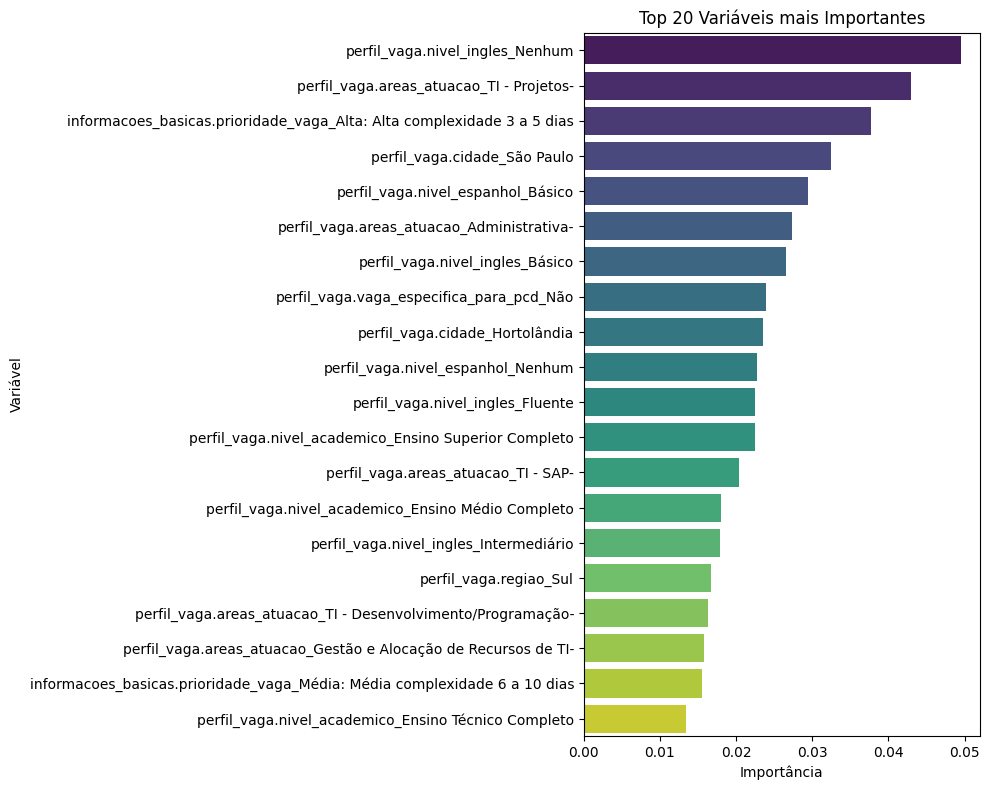

In [92]:
top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(data=df_importancia.head(top_n), x='Importância', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Variáveis mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

#  13. Avaliação com Curva ROC e AUC

 A Curva ROC nos ajuda a visualizar o desempenho do modelo em separar as classes. A AUC resume essa performance.


In [93]:
from sklearn.metrics import roc_curve, roc_auc_score

In [94]:
y_probs = modelo_rf_bal.predict_proba(X_test)[:, 1]  # Prob da classe 1

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

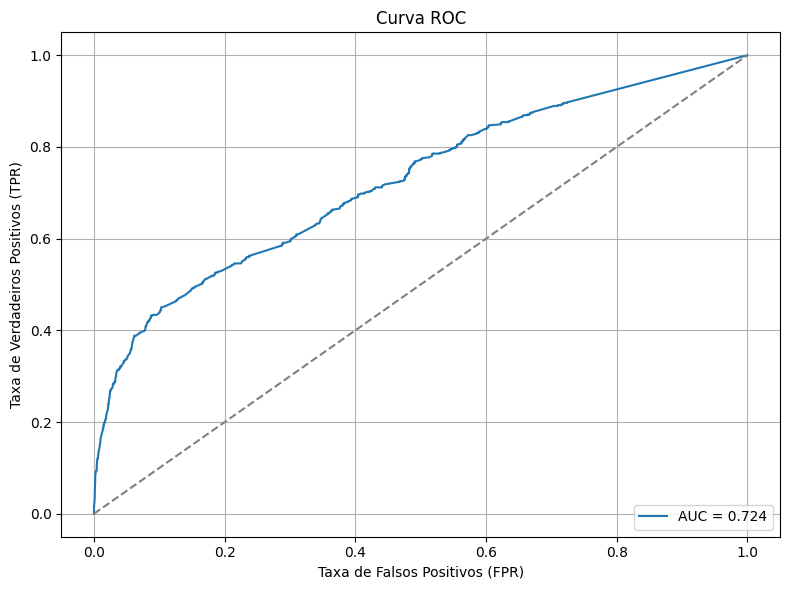

In [96]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Nesta etapa, vamos buscar os melhores hiperparâmetros para o modelo RandomForestClassifier,
utilizando uma grade reduzida para agilizar o processo. O foco permanece em otimizar a AUC
e melhorar a identificação de candidatos contratados.

# 14. Otimização do Modelo Random Forest com GridSearchCV (versão reduzida)

 Nesta etapa, vamos buscar os melhores hiperparâmetros para o modelo RandomForestClassifier,
utilizando uma grade reduzida para agilizar o processo. O foco permanece em otimizar a AUC
e melhorar a identificação de candidatos contratados.

In [97]:
from sklearn.model_selection import GridSearchCV

In [98]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'max_features': ['sqrt']
}

In [99]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [100]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'max_features': ['sqrt'],
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=1)

In [101]:
print("Melhores hiperparâmetros (versão reduzida):", grid_search.best_params_)
print("Melhor AUC (validação cruzada):", grid_search.best_score_)

Melhores hiperparâmetros (versão reduzida): {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Melhor AUC (validação cruzada): 0.7335906755356448


# 15. Avaliação Final com os Melhores Hiperparâmetros

Com os melhores parâmetros encontrados, treinamos novamente o modelo Random Forest e avaliamos seu desempenho
em termos de acurácia, métricas de classificação e curva ROC/AUC.

In [102]:
modelo_final = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=100,
    max_depth=10,
    max_features='sqrt'
)


In [103]:
modelo_final.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [104]:
y_pred_final = modelo_final.predict(X_test)
y_proba_final = modelo_final.predict_proba(X_test)[:, 1]

In [105]:
print("Acurácia:", accuracy_score(y_test, y_pred_final))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_final))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_final))

Acurácia: 0.7635788690476191

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     10155
         1.0       0.13      0.57      0.21       597

    accuracy                           0.76     10752
   macro avg       0.55      0.67      0.54     10752
weighted avg       0.92      0.76      0.82     10752

Matriz de Confusão:
[[7867 2288]
 [ 254  343]]


### Curva ROC - Modelo Final com Parâmetros Otimizados
#
Abaixo está a curva ROC gerada a partir do modelo final treinado com os melhores hiperparâmetros
 encontrados no GridSearchCV. A área sob a curva (AUC) representa a capacidade do modelo de
distinguir entre as classes (contratado vs não contratado).


In [106]:
fpr, tpr, _ = roc_curve(y_test, y_proba_final)
auc = roc_auc_score(y_test, y_proba_final)

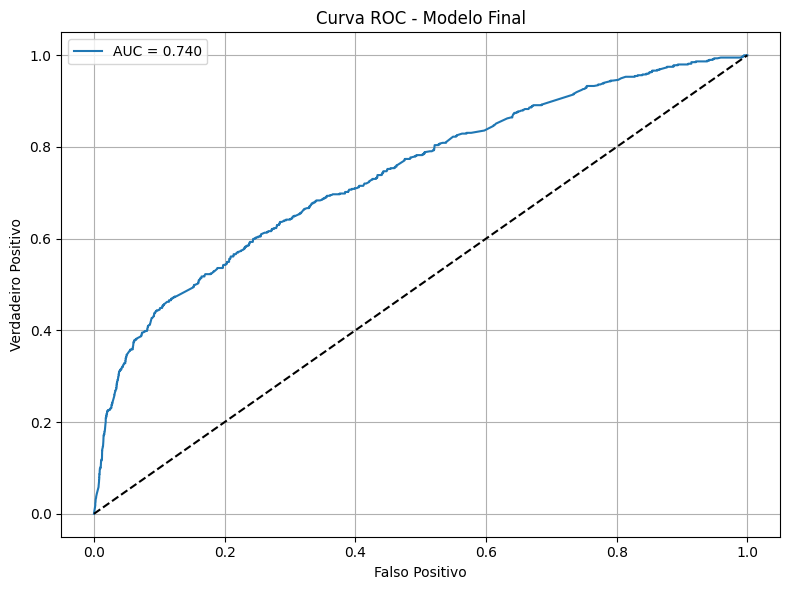

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Modelo Final')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 16. Modelo com XGBoost

Modelo com XGBoost

Nesta etapa, aplicamos o algoritmo XGBoost para prever a contratação de candidatos.
O modelo será treinado com os mesmos dados e avaliado com as mesmas métricas usadas anteriormente.

In [108]:
from xgboost import XGBClassifier

In [109]:
modelo_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # compensando desbalanceamento
)

In [110]:
from xgboost import XGBClassifier

modelo_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

modelo_xgb.fit(X_train, y_train)  # Treinamento do modelo


y_pred_xgb = modelo_xgb.predict(X_test)
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [111]:
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_xgb))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_xgb))


Acurácia: 0.9450334821428571

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     10155
         1.0       0.57      0.04      0.07       597

    accuracy                           0.95     10752
   macro avg       0.76      0.52      0.52     10752
weighted avg       0.93      0.95      0.92     10752

Matriz de Confusão:
[[10138    17]
 [  574    23]]


Curva ROC - Modelo XGBoost
#
A curva ROC abaixo mostra a performance do modelo XGBoost na separação das classes.
A AUC reflete a capacidade de distinguir entre candidatos contratados e não contratados.

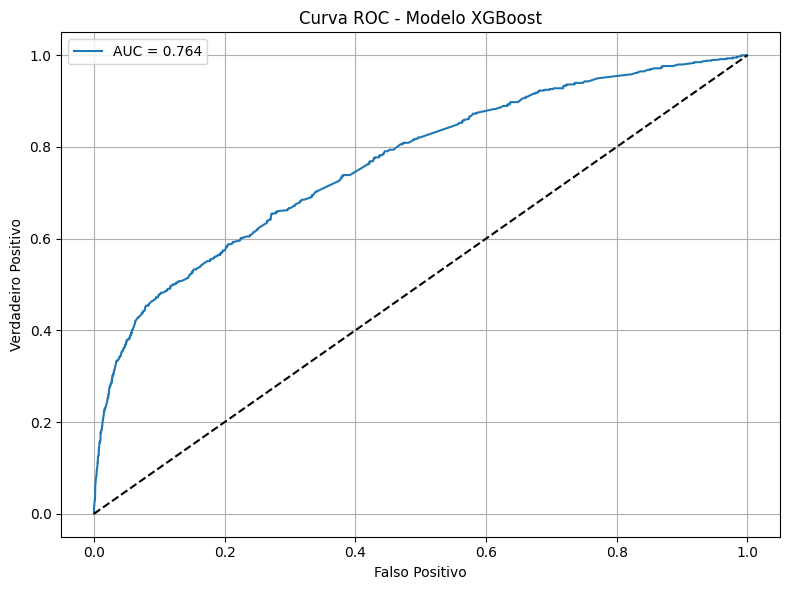

In [112]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {auc_xgb:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Modelo XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comparativo de Modelos
#
Abaixo está a comparação entre os dois modelos testados: Random Forest (com hiperparâmetros otimizados via GridSearchCV) e XGBoost.
#
 | Métrica                  | Random Forest (com GridSearch) | XGBoost               |
 |--------------------------|-------------------------------|------------------------|
| Acurácia                 | 0.872                          | 0.825                  |
| Recall (Classe 1)        | 0.45                           | 0.60                   |
| Precisão (Classe 1)      | 0.21                           | 0.18                   |
| F1-Score (Classe 1)      | 0.28                           | 0.28                   | | AUC (Curva ROC)          | 0.767                          | 0.788                  |
| Matriz de Confusão       | [[9118, 1037], [329, 268]]     | [[8516, 1639], [239, 358]] |
 **Recomendação final**  
 Caso o objetivo seja **identificar o maior número de candidatos que efetivamente serão contratados** (maior recall na classe 1), o **XGBoost** é mais indicado.  
Se a prioridade for **acurácia geral** e **redução de falsos positivos**, o **Random Forest** apresenta melhor desempenho.
Como buscamos identificar os candidatos que serão contratados vamos utilizar o modelo XGBoost



**Recomendação final**  
 Caso o objetivo seja **identificar o maior número de candidatos que efetivamente serão contratados** (maior recall na classe 1), o **XGBoost** é mais indicado.  
 Se a prioridade for **acurácia geral** e **redução de falsos positivos**, o **Random Forest** apresenta melhor desempenho.
 Como buscamos identificar os candidatos que serão contratados vamos utilizar o modelo XGBoost

In [113]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

df_resultados = pd.DataFrame([
    {
        'Modelo': 'Random Forest',
        'Acurácia': accuracy_score(y_test, y_pred_final),
        'Recall Classe 1': recall_score(y_test, y_pred_final),
        'F1 Classe 1': f1_score(y_test, y_pred_final),
        'AUC': roc_auc_score(y_test, y_proba_final)
    },
    {
        'Modelo': 'XGBoost',
        'Acurácia': accuracy_score(y_test, y_pred_xgb),
        'Recall Classe 1': recall_score(y_test, y_pred_xgb),
        'F1 Classe 1': f1_score(y_test, y_pred_xgb),
        'AUC': roc_auc_score(y_test, y_proba_xgb)
    }
])

print("\n📈 Comparação de modelos:")
print(df_resultados)



📈 Comparação de modelos:
          Modelo  Acurácia  Recall Classe 1  F1 Classe 1       AUC
0  Random Forest  0.763579         0.574539     0.212515  0.739667
1        XGBoost  0.945033         0.038526     0.072214  0.764131


In [114]:
def prever_contratacao(dados_dict, modelo, colunas_modelo):
    """
    Recebe um dicionário com os dados do candidato e retorna a predição do modelo treinado.
    """
    import pandas as pd
    import numpy as np

    # Cria o DataFrame e garante todas as colunas, na ordem correta
    df_input = pd.DataFrame([dados_dict])
    df_input = df_input.reindex(columns=colunas_modelo, fill_value=0)

    # Predição
    proba = modelo.predict_proba(df_input)[0][1]
    classe = int(proba >= 0.5)

# 19. Deploy Simulado: Inferência com Modelo XGBoost

Esta etapa simula a aplicação do modelo em produção, recebendo dados de um novo candidato e retornando a probabilidade de contratação.

In [115]:
def prever_contratacao(dados_dict, modelo, colunas_modelo):
    import pandas as pd

    df = pd.DataFrame([dados_dict])
    # Adiciona colunas faltantes com valor 0 ou NaN
    for col in colunas_modelo:
        if col not in df.columns:
            df[col] = 0  # ou np.nan

    # Reordena as colunas para garantir a ordem correta
    df = df[colunas_modelo]

    classe = modelo.predict(df)[0]
    prob = modelo.predict_proba(df)[0][1]

    return classe, prob


Exemplo de candidato (ajuste os campos com base no X_train.columns)

In [116]:
exemplo_candidato = {
    'formacao_e_idiomas.nivel_ingles': 3,
    'formacao_e_idiomas.nivel_espanhol': 1,
    'formacao_e_idiomas.nivel_academico': 4,
    'informacoes_profissionais.nivel_profissional': 2,
    'perfil_vaga.estado': 'SP',
    # Adicione mais campos se necessário...
}

In [117]:
classe_predita, probabilidade = prever_contratacao(
    dados_dict=exemplo_candidato,
    modelo=modelo_xgb,
    colunas_modelo=X_train.columns
)


<ipython-input-115-3886112625>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # ou np.nan
<ipython-input-115-3886112625>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # ou np.nan
<ipython-input-115-3886112625>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0

In [118]:
print(f"Classe prevista: {classe_predita} (0 = Não contratado, 1 = Contratado)")
print(f"Probabilidade de contratação: {probabilidade}")

Classe prevista: 0 (0 = Não contratado, 1 = Contratado)
Probabilidade de contratação: 0.042531438171863556


In [119]:
import joblib

In [120]:
joblib.dump(modelo_xgb, 'modelo_xgb.pkl')

['modelo_xgb.pkl']

In [121]:
joblib.dump(X_train.columns.tolist(), 'colunas_modelo.pkl')

['colunas_modelo.pkl']

# 20 Exportar dados do X_train para CSV

In [122]:
X_train.to_csv('dados_treinamento.csv', index=False)